In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
    
'''
import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.utils import np_utils
'''
 
from nariflow import Variable
from nariflow import optimizer
from nariflow import GradientTape
#from nariflow import calc_gradient
from nariflow import layer
from nariflow.models import Model
from nariflow import functions as f
from nariflow.core import elementary_function as ef
from nariflow.core import shape_function as sf

import tensorflow as tf
from tensorflow.python.framework import function
import math
 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score

#import lightgbm as lgb
 
import scipy

#import statsmodels.api
#import statsmodels as sm
 
import copy
import random
import time
from time import sleep

import re
import os

import networkx as nx

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [3]:
os.listdir("data")

['179502b7cf14f003d.png',
 'dangjin_fcst_data.csv',
 'dangjin_obs_data.csv',
 'energy.csv',
 'obs',
 'OBS_ASOS_TIM_20210509142735.csv',
 'OBS_ASOS_TIM_20210509143013.csv',
 'OBS_ASOS_TIM_20210509143059.csv',
 'OBS_ASOS_TIM_20210525163946.csv',
 'OBS_ASOS_TIM_20210525164100.csv',
 'OBS_ASOS_TIM_20210525164127.csv',
 'OBS_ASOS_TIM_20210526161235.csv',
 'OBS_ASOS_TIM_20210526161318.csv',
 'OBS_ASOS_TIM_20210526161340.csv',
 'OBS_ASOS_TIM_20210526161401.csv',
 'OBS_ASOS_TIM_20210526161419.csv',
 'OBS_ASOS_TIM_20210526161438.csv',
 'sample_submission.csv',
 'site_info.csv',
 'ulsan_fcst_data.csv',
 'ulsan_obs_data.csv',
 'weather',
 '석문면_강수형태_201801_201812.csv',
 '석문면_강수형태_201901_201912.csv',
 '석문면_강수형태_202001_202012.csv',
 '석문면_강수형태_202101_202102.csv',
 '석문면_강수확률_201801_201812.csv',
 '석문면_강수확률_201901_201912.csv',
 '석문면_강수확률_202001_202012.csv',
 '석문면_강수확률_202101_202102.csv',
 '선암동_강수형태_201801_201812.csv',
 '선암동_강수형태_201901_201912.csv',
 '선암동_강수형태_202001_202012.csv',
 '선암동_강수형태_202101_202102

# 1. Data Load

In [4]:
dangjin_fcst = pd.read_csv("data/dangjin_fcst_data.csv")
dangjin_obs = pd.read_csv("data/dangjin_obs_data.csv")
energy = pd.read_csv("data/energy.csv")
site_info = pd.read_csv("data/site_info.csv")
ulsan_fcst = pd.read_csv("data/ulsan_fcst_data.csv")
ulsan_obs = pd.read_csv("data/ulsan_obs_data.csv")

## 1) 데이터 준비

### (1) Forecast Time 변환

In [5]:
dangjin_fcst["forecast"] = pd.to_datetime(dangjin_fcst["Forecast time"]) + dangjin_fcst["forecast"].apply(
    lambda x : pd.Timedelta(x, unit = "H"))

In [6]:
ulsan_fcst["forecast"] = pd.to_datetime(ulsan_fcst["Forecast time"]) + ulsan_fcst["forecast"].apply(
    lambda x : pd.Timedelta(x, unit = "H"))

# 2. EDA

## 1) 기초 통계 및 결측, 이상치 확인

### (1) 결측치

In [7]:
print(dangjin_fcst.isna().apply(lambda x : x.value_counts()))
print(dangjin_obs.isna().apply(lambda x : x.value_counts()))
print(energy.isna().apply(lambda x : x.value_counts()))
print(site_info.isna().apply(lambda x : x.value_counts()))
print(ulsan_fcst.isna().apply(lambda x : x.value_counts()))
print(ulsan_obs.isna().apply(lambda x : x.value_counts()))

       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud  
False         162208  162208  
            지점      지점명       일시  기온(°C)  풍속(m/s)  풍향(16방위)  습도(%)  전운량(10분위)
False  25626.0  25626.0  25626.0   25589    25590     25590  25591      21656
True       NaN      NaN      NaN      37       36        36     35       3970
          time  dangjin_floating  dangjin_warehouse  dangjin    ulsan
False  25632.0             25608              25584  25632.0  25632.0
True       NaN                24                 48      NaN      NaN
       Id  Capacity  Address  InstallationAngle  IncidentAngle  Latitude  \
False   4         4        4                  4              4         4   

       Longitude  
False          4  
       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud 

Forecast엔 결측치가 없고, obs엔 결측치가 소수 존재한다. Energy 결측치는 이유에 대한 탐색이 필요해보인다.

#### - Energy 결측 탐색

In [8]:
energy.loc[energy["dangjin_warehouse"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
384,2018-03-17 1:00:00,0.0,NaN,0,0
385,2018-03-17 2:00:00,0.0,NaN,0,0
386,2018-03-17 3:00:00,0.0,NaN,0,0
387,2018-03-17 4:00:00,0.0,NaN,0,0
388,2018-03-17 5:00:00,0.0,NaN,0,0
389,2018-03-17 6:00:00,0.0,NaN,0,0
390,2018-03-17 7:00:00,0.0,NaN,0,0
391,2018-03-17 8:00:00,24.0,NaN,16,13
392,2018-03-17 9:00:00,162.0,NaN,177,57
393,2018-03-17 10:00:00,363.0,NaN,348,206


In [9]:
energy.loc[energy["dangjin_floating"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
20352,2020-06-26 1:00:00,NaN,0.0,0,0
20353,2020-06-26 2:00:00,NaN,0.0,0,0
20354,2020-06-26 3:00:00,NaN,0.0,0,0
20355,2020-06-26 4:00:00,NaN,0.0,0,0
20356,2020-06-26 5:00:00,NaN,0.0,0,0
20357,2020-06-26 6:00:00,NaN,0.0,0,0
20358,2020-06-26 7:00:00,NaN,7.0,2,7
20359,2020-06-26 8:00:00,NaN,20.0,18,50
20360,2020-06-26 9:00:00,NaN,148.0,175,161
20361,2020-06-26 10:00:00,NaN,242.0,330,170


Enegry 내부에선 상관성이 있는 변수가 없어보인다.

정확히 하루 단위로 데이터가 NA이므로, 삭제해도 무방할 것으로 판단됨

In [10]:
energy = energy.dropna().reset_index(drop = True)

#### - obs 결측 탐색

In [11]:
dangjin_obs.isna().apply(lambda x : x.value_counts())

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
False,25626.0,25626.0,25626.0,25589,25590,25590,25591,21656
True,NaN,NaN,NaN,37,36,36,35,3970


In [12]:
dangjin_fcst[dangjin_fcst["Forecast time"] == '2019-01-31 11:00:00']

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
49728,2019-01-31 11:00:00,2019-01-31 15:00:00,-1.0,40.0,9.0,328.0,4.0
49729,2019-01-31 11:00:00,2019-01-31 18:00:00,-3.0,45.0,9.2,323.0,3.0
49730,2019-01-31 11:00:00,2019-01-31 21:00:00,-3.0,50.0,10.9,320.0,3.0
49731,2019-01-31 11:00:00,2019-02-01 00:00:00,-4.0,50.0,10.1,319.0,2.0
49732,2019-01-31 11:00:00,2019-02-01 03:00:00,-2.0,60.0,8.8,320.0,3.0
49733,2019-01-31 11:00:00,2019-02-01 06:00:00,-2.0,70.0,5.9,318.0,3.0
49734,2019-01-31 11:00:00,2019-02-01 09:00:00,-2.0,70.0,2.9,252.0,3.0
49735,2019-01-31 11:00:00,2019-02-01 12:00:00,2.0,45.0,7.5,284.0,2.0
49736,2019-01-31 11:00:00,2019-02-01 15:00:00,4.0,45.0,8.1,275.0,2.0
49737,2019-01-31 11:00:00,2019-02-01 18:00:00,1.0,65.0,7.5,269.0,1.0


In [13]:
dangjin_obs[dangjin_obs["일시"].str.slice(0,10) == '2019-01-31']

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
8058,129,서산,2019-01-31 00:00,1.4,0.1,0.0,85.0,10.0
8059,129,서산,2019-01-31 01:00,1.3,0.4,0.0,87.0,10.0
8060,129,서산,2019-01-31 02:00,2.3,1.3,20.0,88.0,10.0
8061,129,서산,2019-01-31 03:00,1.8,1.0,20.0,80.0,10.0
8062,129,서산,2019-01-31 04:00,1.6,2.5,360.0,56.0,10.0
8063,129,서산,2019-01-31 05:00,1.0,1.9,360.0,51.0,10.0
8064,129,서산,2019-01-31 06:00,0.6,1.4,360.0,48.0,10.0
8065,129,서산,2019-01-31 07:00,0.3,2.9,360.0,48.0,10.0
8066,129,서산,2019-01-31 08:00,-0.3,2.4,360.0,45.0,10.0
8067,129,서산,2019-01-31 09:00,-0.6,2.7,360.0,44.0,10.0


기온, 풍속, 풍향, 습도 결측치는 서로 밀접한 연관이 있는 것으로 보인다.

활용이 불가능하므로 제외한다.

In [14]:
dangjin_obs = dangjin_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "풍향(16방위)", "습도(%)"]).reset_index(drop = True)

### - 전운량 결측 탐색

In [15]:
dangjin_obs["전운량(10분위)"].isna().value_counts()

False    21618
True      3970
Name: 전운량(10분위), dtype: int64

In [16]:
dangjin_obs = dangjin_obs.rename(columns = {"일시" : "forecast"})

dangjin_obs["forecast"] = pd.to_datetime(dangjin_obs["forecast"])

In [17]:
dangjin_obs["date"] = dangjin_obs["forecast"].dt.date
dangjin_obs["hour"] = dangjin_obs["date"].astype("str") + " " + dangjin_obs["forecast"].dt.hour.astype("str")

<AxesSubplot:>

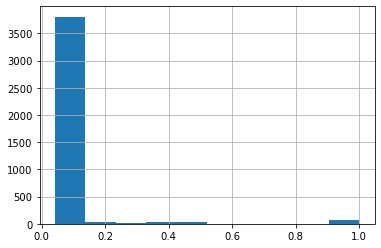

In [18]:
# 하루 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("date").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

최초 예상으로는 전운량이 Na인 경우 하루 전체가 다 그럴것이라는 가설을 세웠지만

그 가설은 사실이 아닌것으로 판명되었다.

<AxesSubplot:>

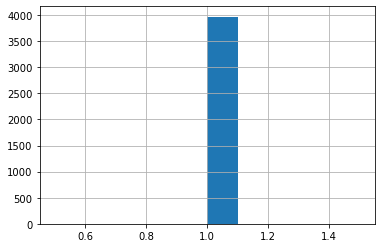

In [19]:
# 시간 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("hour").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

## 2) 파생 변수 생성 전략 탐색

### (1) obs의 전운량과 fcst의 cloud간 비교 

#### - 데이터 Merge

In [20]:
result = pd.merge(dangjin_obs, dangjin_fcst, on = "forecast", how = "left")

#### - 상관계수

In [21]:
result[["Cloud","전운량(10분위)"]].corr()

,Cloud,전운량(10분위)
Cloud,1.00000,0.54449
전운량(10분위),0.54449,1.00000


상관도가 생각보다 낮다. 예측과 실제값 사이에 괴리감이 큰 것으로 보인다.

#### - 오차값(잔차) 확인

잔차를 확인하면 이를 이용하여 예측값에서 실제 정답값을 유사하게라도 보정할 수 있지 않을까?

히스토그램을 그려 잔차가 정규분포를 따르는지 확인하고, 실제 정규성 검정을 수행해본다.

(array([ 4267., 10232., 22770., 29142.,  9112.,  7611., 13987., 23917.,
         5448.,  6340.]),
 array([-9. , -7.7, -6.4, -5.1, -3.8, -2.5, -1.2,  0.1,  1.4,  2.7,  4. ]),
 <BarContainer object of 10 artists>)

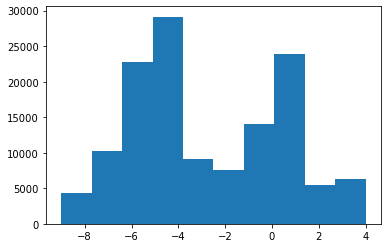

In [22]:
plt.hist(result["Cloud"] - result["전운량(10분위)"])

쌍봉 분포를 보인다. 

차이가 전혀 없는 경우(평균이 0인 정규분포)와 차이가 5~6정도 나는 경우(평균이 5인 정규분포)로 나뉘는 것으로 보인다.

In [23]:
scipy.stats.kstest((result["Cloud"] - result["전운량(10분위)"]).dropna(), "norm")

KstestResult(statistic=0.6031363661771878, pvalue=0.0)

아쉽게도, 잔차는 정규분포를 따르지 않는다.

In [24]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]

,지점,지점명,forecast,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위),date,hour,Forecast time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
25226,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 05:00:00,34.0,55.0,4.1,269.0,1.0
25227,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 08:00:00,34.0,55.0,4.1,269.0,1.0
25228,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 11:00:00,33.0,55.0,4.1,269.0,1.0
25229,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 14:00:00,33.0,55.0,4.1,269.0,1.0
25230,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 17:00:00,33.0,55.0,2.4,294.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174529,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-30 02:00:00,6.0,75.0,2.9,180.0,3.0
174538,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 05:00:00,6.0,75.0,3.3,168.0,3.0
174539,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 08:00:00,6.0,75.0,3.3,168.0,3.0
174540,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 11:00:00,6.0,75.0,3.3,168.0,3.0


<AxesSubplot:>

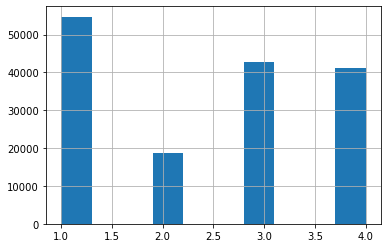

In [25]:
result["Cloud"].hist()

<AxesSubplot:>

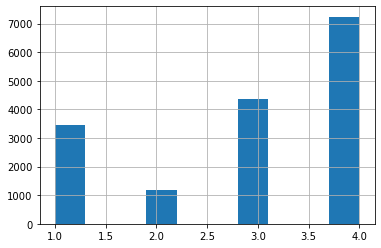

In [26]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["Cloud"].hist()

<AxesSubplot:>

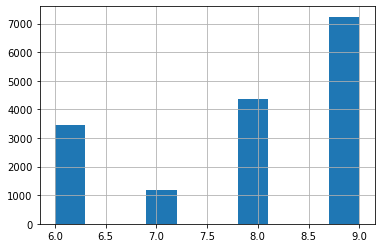

In [27]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["전운량(10분위)"].hist()

전운량의 예측은 1 ~ 4밖에 없다. 

예측 오차가 크게 나는 경우는 실제 전운량이 6 이상으로 나타나는 경우였다.

In [28]:
dangjin_fcst.describe()

,Temperature,Humidity,WindSpeed,WindDirection,Cloud
count,162208.000000,162208.000000,162208.000000,162208.000000,162208.000000
mean,12.624634,76.996147,3.639262,214.147761,2.439411
std,9.816256,17.435418,2.627592,108.020035,1.214753
min,-14.000000,5.000000,0.000000,0.000000,1.000000
25%,4.000000,65.000000,1.900000,115.000000,1.000000
50%,13.000000,80.000000,2.800000,237.000000,3.000000
75%,21.000000,90.000000,4.600000,313.000000,4.000000
max,36.000000,100.000000,32.299999,360.000000,4.000000


## 2) 변수 선별

### (1) 변수 선별용 데이터 전처리

#### - X, y 데이터 생성

In [29]:
temp = DataFrame(list(DataFrame(list(energy["time"].str.split(" ")))[1].str.split(":")))

In [30]:
energy["time"] = pd.to_datetime(
    DataFrame(list(energy["time"].str.split(" ")))[0] + 
    " " 
    + (temp[0].astype("int") - 1).astype("str") + ":" + temp[1] + ":" + temp[2])

In [31]:
energy_obs = pd.merge(energy, dangjin_obs, left_on = "time", right_on = "forecast", how = "left")

In [32]:
energy_obs = energy_obs.dropna().reset_index(drop = True)

energy_obs = energy_obs.drop(["date","hour", "지점", "지점명", "forecast"], axis = 1)

#### - 일출 일몰 정보 생성

In [33]:
def day_night(x):
    if x < 6 or x > 18:
        return 0
    else:
        return 1

In [34]:
energy_obs["day_night"] = energy_obs["time"].dt.hour.apply(lambda x : day_night(int(x)))

# 3. 데이터 전처리

## 1) 결측값 대체

### (1) fcst 보간

#### - spline 보간

In [35]:
energy['time'] = energy['time'].astype('str')

In [36]:
temp = DataFrame(list(DataFrame(list(energy["time"].str.split(" ")))[1].str.split(":")))

energy["time"] = pd.to_datetime(
    DataFrame(list(energy["time"].str.split(" ")))[0] + 
    " " 
    + (temp[0].astype("int") - 1).astype("str") + ":" + temp[1] + ":" + temp[2])

energy = energy.dropna().reset_index(drop = True)

In [37]:
def time_interpolate(x, data):
    
    temp = data[data["time"].dt.date == x].drop_duplicates("time", keep = "last")
    
    min_time = np.min(temp["time"])
    
    max_time = min_time + pd.Timedelta(hours = 23)
    
    time_index = pd.date_range(min_time, max_time, freq = "H")
    
    temp = pd.merge(pd.Series(pd.date_range(min_time, max_time, freq = "H"),name = "time"),
         temp,
         how = "left")
    
    return temp

In [38]:
dangjin_fcst = dangjin_fcst.dropna(axis = 0, subset = ["Temperature","Humidity", "WindSpeed", "WindDirection"]).reset_index(drop = True)

dangjin_fcst["Forecast time"] = pd.to_datetime(dangjin_fcst["Forecast time"])

dangjin_fcst = dangjin_fcst.rename(columns = {"forecast":"time"})

result = pd.Series(dangjin_fcst["time"].dt.date.unique()).apply(lambda x : time_interpolate(x, dangjin_fcst))

dangjin_fcst = pd.concat(list(result))

del dangjin_fcst["Forecast time"]

dangjin_fcst = dangjin_fcst.drop_duplicates("time").reset_index(drop = True)

In [39]:
dangjin_fcst.iloc[:,1:] = dangjin_fcst.iloc[:,1:].apply(lambda x : x.interpolate(method = "spline", order = 2))

In [40]:
ulsan_fcst = ulsan_fcst.dropna(axis = 0, subset = ["Temperature","Humidity", "WindSpeed", "WindDirection"]).reset_index(drop = True)

ulsan_fcst["Forecast time"] = pd.to_datetime(ulsan_fcst["Forecast time"])

ulsan_fcst = ulsan_fcst.rename(columns = {"forecast":"time"})

result = pd.Series(ulsan_fcst["time"].dt.date.unique()).apply(lambda x : time_interpolate(x, ulsan_fcst))

ulsan_fcst = pd.concat(list(result))

del ulsan_fcst["Forecast time"]

ulsan_fcst = ulsan_fcst.drop_duplicates("time").reset_index(drop = True)

In [41]:
ulsan_fcst.iloc[:,1:] = ulsan_fcst.iloc[:,1:].apply(lambda x : x.interpolate(method = "spline", order = 2))

## 2) 파생 변수 생성

### (1) day_night 변수 추가

In [42]:
def day_night(x):
    if x < 5 or x > 19:
        return 0
    else:
        return 1

In [43]:
dangjin_fcst["day_night"] = dangjin_fcst["time"].dt.hour.apply(lambda x : day_night(int(x)))

In [44]:
ulsan_fcst["day_night"] = ulsan_fcst["time"].dt.hour.apply(lambda x : day_night(int(x)))

### (2) 월 변수 추가

#### - dangjin

In [45]:
temp = pd.DataFrame(dangjin_fcst["time"]).copy()

In [46]:
temp["month"] = dangjin_fcst["time"].dt.month
temp["year"] = dangjin_fcst["time"].dt.year
temp["year"] = temp["year"].apply(lambda x : int(np.where(temp["year"].unique() == x)[0]))
temp["day"] = dangjin_fcst["time"].dt.day

temp["hour"] = dangjin_fcst["time"].dt.hour

In [47]:
dangjin_fcst = pd.merge(dangjin_fcst, temp, how = "left")

In [48]:
energy_fcst_dangjin = pd.merge(energy, dangjin_fcst).dropna()

#### - ulsan

In [49]:
temp = pd.DataFrame(ulsan_fcst["time"]).copy()

In [50]:
temp["month"] = ulsan_fcst["time"].dt.month
temp["year"] = ulsan_fcst["time"].dt.year
temp["year"] = temp["year"].apply(lambda x : int(np.where(temp["year"].unique() == x)[0]))
temp["day"] = ulsan_fcst["time"].dt.day

temp["hour"] = ulsan_fcst["time"].dt.hour

In [51]:
ulsan_fcst = pd.merge(ulsan_fcst, temp)

In [52]:
energy_fcst_ulsan = pd.merge(energy, ulsan_fcst, how = "left").dropna()

# 4. 모델링

## 1) train_test 분할

### (1) 당진 분할

In [53]:
temp = DataFrame(energy_fcst_dangjin["time"].dt.date)

In [54]:
def gen():
    n = 0
    while True:
        n += 1
        yield n
        
num = gen()

In [55]:
temp = temp.groupby("time").apply(lambda x : next(num))

temp = temp.reset_index(name = "num")
temp.columns = ["date","num"]

energy_fcst_dangjin["date"] = energy_fcst_dangjin["time"].dt.date

energy_fcst_dangjin = pd.merge(energy_fcst_dangjin, temp)

k = energy_fcst_dangjin.groupby("num").apply(lambda x : len(x) / 24)

k = k.reset_index(name = "ratio")

k_full = DataFrame(list(set(k["num"]).difference(set(k.loc[k["ratio"] < 1, "num"]))),
         columns = ["num"])

energy_fcst_dangjin = pd.merge(k_full, 
         energy_fcst_dangjin,
         how = "left")

#train_num = np.random.choice(energy_fcst_dangjin["num"].unique(),
#              size = int(len(energy_fcst_dangjin["num"].unique()) * 0.75),
#                replace = False)

train_num = [i for i in range(0, len(energy_fcst_dangjin["num"].unique()) - 30)]

test_num = [i for i in range(len(energy_fcst_dangjin["num"].unique()) - 30, 
                            len(energy_fcst_dangjin["num"].unique()))]

train = pd.merge(DataFrame(train_num, columns = ["num"]), energy_fcst_dangjin)

test = pd.merge(DataFrame(test_num, columns = ["num"]), energy_fcst_dangjin)

X_train_dangjin = train[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",
                         "num"]]

X_train_dangjin = X_train_dangjin.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",]].to_numpy())

X_test_dangjin = test[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",
                       "num"]]

X_test_dangjin = X_test_dangjin.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",]].to_numpy())

X_train_dangjin = np.stack(X_train_dangjin)
X_test_dangjin = np.stack(X_test_dangjin)

In [56]:
y_train_dangjin = train[["num","dangjin"]]
y_test_dangjin = test[["num","dangjin"]]

y_train_dangjin = np.stack(y_train_dangjin.groupby("num").apply(lambda x : np.array(x["dangjin"])))
y_test_dangjin = np.stack(y_test_dangjin.groupby("num").apply(lambda x : np.array(x["dangjin"])))

In [57]:
y_train_dangjin_ware = train[["num","dangjin_warehouse"]]
y_test_dangjin_ware = test[["num","dangjin_warehouse"]]

y_train_dangjin_ware = np.stack(y_train_dangjin_ware.groupby("num").apply(lambda x : np.array(x["dangjin_warehouse"])))
y_test_dangjin_ware = np.stack(y_test_dangjin_ware.groupby("num").apply(lambda x : np.array(x["dangjin_warehouse"])))

In [58]:
y_train_dangjin_float = train[["num","dangjin_floating"]]
y_test_dangjin_float = test[["num","dangjin_floating"]]

y_train_dangjin_float = np.stack(y_train_dangjin_float.groupby("num").apply(lambda x : np.array(x["dangjin_floating"])))
y_test_dangjin_float = np.stack(y_test_dangjin_float.groupby("num").apply(lambda x : np.array(x["dangjin_floating"])))

### (2) 울산 분할

In [59]:
temp = DataFrame(energy_fcst_ulsan["time"].dt.date)

In [60]:
temp = temp.groupby("time").apply(lambda x : next(num))

temp = temp.reset_index(name = "num")
temp.columns = ["date","num"]

energy_fcst_ulsan["date"] = energy_fcst_ulsan["time"].dt.date

energy_fcst_ulsan = pd.merge(energy_fcst_ulsan, temp)

k = energy_fcst_ulsan.groupby("num").apply(lambda x : len(x) / 24)

In [61]:
k = k.reset_index(name = "ratio")

k_full = DataFrame(list(set(k["num"]).difference(set(k.loc[k["ratio"] < 1, "num"]))),
         columns = ["num"])

energy_fcst_ulsan = pd.merge(k_full, 
         energy_fcst_ulsan,
         how = "left")

#train_num = np.random.choice(energy_fcst_dangjin["num"].unique(),
#              size = int(len(energy_fcst_dangjin["num"].unique()) * 0.75),
#                replace = False)

train_num = [i for i in range(np.min(energy_fcst_ulsan["num"].unique()), 
                              np.max(energy_fcst_ulsan["num"].unique()) - 30)]

test_num = [i for i in range(np.max(energy_fcst_ulsan["num"].unique()) - 30, 
                            np.max(energy_fcst_ulsan["num"].unique()) + 1)]

train = pd.merge(DataFrame(train_num, columns = ["num"]), energy_fcst_ulsan)

test = pd.merge(DataFrame(test_num, columns = ["num"]), energy_fcst_ulsan)

X_train_ulsan = train[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",
                         "num"]]

X_train_ulsan = X_train_ulsan.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",]].to_numpy())

X_test_ulsan = test[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",
                       "num"]]

X_test_ulsan = X_test_ulsan.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",]].to_numpy())

X_train_ulsan = np.stack(X_train_ulsan)
X_test_ulsan = np.stack(X_test_ulsan)

In [62]:
y_train_ulsan = train[["num","ulsan"]]
y_test_ulsan = test[["num","ulsan"]]

y_train_ulsan = np.stack(y_train_ulsan.groupby("num").apply(lambda x : np.array(x["ulsan"])))
y_test_ulsan = np.stack(y_test_ulsan.groupby("num").apply(lambda x : np.array(x["ulsan"])))

### 1) RNN testing

### (1) min_max_scale

In [63]:
train_min_dangjin = np.min(X_train_dangjin)
train_max_dangjin = np.max(X_train_dangjin)

X_train_dangjin_scaled = (X_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

X_test_dangjin_scaled = (X_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

#X_train_dangjin_scaled[:,:,4] = X_train_dangjin[:,:,4]

#X_test_dangjin_scaled[:,:,4] = X_test_dangjin[:,:,4]

In [64]:
y_train_dangjin_scaled = (y_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_scaled = (y_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [65]:
y_train_dangjin_ware_scaled = (y_train_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_ware_scaled = (y_test_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [66]:
y_train_dangjin_float_scaled = (y_train_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_float_scaled = (y_test_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

#### - nariflow  테스트

In [275]:
EPOCHS = 30
batch_size = 50

In [276]:
class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = layer.RNN(hidden_size)
        #self.l2 = layer.LSTM(int(hidden_size / 2))
        #self.l3 = layer.LSTM(hidden_size)
        self.l4 = layer.Linear(out_size, initializer_func='he_uniform')
        
    def forward(self, x):
        y = self.l1(x)
        #y = self.l2(y)
        #y = self.l3(y)
        y = self.l4(y)
        return y
    

In [277]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()
 
model = SimpleRNN(100, 1)
optimizers = optimizer.Adam(0.001)
optimizers.setup(model)
    
for epoch in range(EPOCHS):
    start = time.time()
    for mini in range(1, int(X_train_dangjin_scaled.shape[0] / batch_size) + 2):
        inp = Variable(X_train_dangjin_scaled[(mini - 1) * batch_size : (mini * batch_size)][:,:23,:])
        tar = Variable(y_train_dangjin_scaled[(mini - 1) * batch_size : (mini * batch_size)][:,1:])

        for teps in range(inp.shape()[1]):
            with GradientTape() as tape:    
                y_pred = model(inp[:,teps,:])
                loss = f.loss.mean_squared_error(sf.reshape(y_pred, [-1]), tar[:,teps])
            tape.CalcGradient()
            optimizers.update()
            model.l1.reset_state()
            #model.l2.reset_state()
            #model.l3.reset_state()

        if mini % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {mini} Loss {loss.data} Accuracy ')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 5 Loss 2.022078477145017 Accuracy 
Epoch 1 Batch 10 Loss 2.565139651118013 Accuracy 
Epoch 1 Batch 15 Loss 0.8588157049038213 Accuracy 
Epoch 1 Batch 20 Loss 1.365977518360993 Accuracy 
Time taken for 1 epoch: 2.20 secs

Epoch 2 Batch 5 Loss 2.031365314697253 Accuracy 
Epoch 2 Batch 10 Loss 2.3632415891650873 Accuracy 
Epoch 2 Batch 15 Loss 0.9272365317057539 Accuracy 
Epoch 2 Batch 20 Loss 1.411885169362899 Accuracy 
Time taken for 1 epoch: 2.22 secs

Epoch 3 Batch 5 Loss 1.9568615568722854 Accuracy 
Epoch 3 Batch 10 Loss 2.309255504822481 Accuracy 
Epoch 3 Batch 15 Loss 0.9604945552020507 Accuracy 
Epoch 3 Batch 20 Loss 1.4430205273766163 Accuracy 
Time taken for 1 epoch: 2.46 secs

Epoch 4 Batch 5 Loss 1.915065483074437 Accuracy 
Epoch 4 Batch 10 Loss 2.3040460473109703 Accuracy 
Epoch 4 Batch 15 Loss 0.9665482442085193 Accuracy 
Epoch 4 Batch 20 Loss 1.471158511135156 Accuracy 
Time taken for 1 epoch: 2.26 secs

Epoch 5 Batch 5 Loss 1.890850884953852 Accuracy 
Epoch 5

In [278]:
pred_result = list()
for teps in range(inp.shape()[1]):
    pred_result.append(model(inp[0,teps,:]))
    model.l1.reset_state()

In [279]:
[i.data for i in pred_result]

[array([1.20688276]),
 array([1.20688276]),
 array([1.31619723]),
 array([1.06297397]),
 array([0.96435696]),
 array([0.81258261]),
 array([0.77509604]),
 array([0.76456306]),
 array([0.86033274]),
 array([0.88358053]),
 array([0.901895]),
 array([0.87111356]),
 array([0.89434775]),
 array([0.91770855]),
 array([1.03145179]),
 array([1.14982094]),
 array([1.35908992]),
 array([1.41745779]),
 array([1.42563767]),
 array([1.28045718]),
 array([1.19352393]),
 array([1.09965914]),
 array([1.08138075])]

### - 텐서플로우 테스트

In [286]:
class TrainModel(tf.keras.Model):
    def __init__(self, 
                 kernel_size, 
                 lstm_dim):
        
        super(TrainModel, self).__init__()

        self.kernel_size = kernel_size
        self.lstm_dim = lstm_dim
     
    def build(self, input_shape):
        
        self.lstm = tf.keras.layers.SimpleRNN(self.lstm_dim,
                                        return_sequences = True)
        
        output_layer = tf.keras.layers.Dense(1, activation = "relu")
        
        self.outputs = tf.keras.layers.TimeDistributed(output_layer)
    
    def call(self, input_tensor):
        
        lstm_output_1 = self.lstm(input_tensor)
        
        output = self.outputs(lstm_output_1)
        
        return output

In [287]:
Models_dangjin = TrainModel(
                     kernel_size = 200, 
                      lstm_dim = 100)

In [288]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [289]:
@tf.function()
def train_step_dangjin(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Models_dangjin(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_dangjin.trainable_variables)
    optimizer_tf.apply_gradients(zip(gradients, Models_dangjin.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [290]:
def val_accuracy(inp, tar, Models):
    output = Models(inp)
    
    test_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [291]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(EPOCHS):
    start = time.time()   
    i = 1
    while True:
        
        train_loss.reset_state()
        
        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_ware_scaled, Models_dangjin)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 3.6931 Accuracy 37.5552
Epoch 1 Batch 10 Loss 2.2066 Accuracy 30.0919
Epoch 1 Batch 15 Loss 1.1516 Accuracy 24.7223
Epoch 1 Batch 20 Loss 1.1689 Accuracy 22.7387
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 11.3522
Epoch 2 Batch 5 Loss 1.0794 Accuracy 21.4876
Epoch 2 Batch 10 Loss 1.2159 Accuracy 20.4667
Epoch 2 Batch 15 Loss 1.4236 Accuracy 19.3702
Epoch 2 Batch 20 Loss 0.9095 Accuracy 18.7920
Time taken for 1 epoch: 0.12 secs

TestLoss 0.0000 TestAccuracy 12.7545
Epoch 3 Batch 5 Loss 0.9860 Accuracy 18.3875
Epoch 3 Batch 10 Loss 1.2928 Accuracy 18.1722
Epoch 3 Batch 15 Loss 1.2758 Accuracy 17.6928
Epoch 3 Batch 20 Loss 0.8418 Accuracy 17.4736
Time taken for 1 epoch: 0.13 secs

TestLoss 0.0000 TestAccuracy 13.2066
Epoch 4 Batch 5 Loss 0.9092 Accuracy 17.2245
Epoch 4 Batch 10 Loss 1.2655 Accuracy 17.1256
Epoch 4 Batch 15 Loss 1.2958 Accuracy 16.8340
Epoch 4 Batch 20 Loss 0.8375 Accuracy 16.7328
Time taken for 1 epoch: 0.12 secs

TestLoss 0.0000 T

결론 : 동일한 구조와 동일한 Loss값(MeanSquaredError)를 주었을 때 나리플로우와 텐서플로우는 모두 비슷한 수준으로 훈련 LOSS가 줄어든다.

In [292]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()
 
model = SimpleRNN(100, 1)
optimizers = optimizer.Adam(0.001)
optimizers.setup(model)
    
for epoch in range(EPOCHS):
    start = time.time()
    for mini in range(1, int(X_train_dangjin_scaled.shape[0] / batch_size) + 2):
        inp = Variable(X_train_dangjin_scaled[(mini - 1) * batch_size : (mini * batch_size)][:,:23,:])
        tar = Variable(y_train_dangjin_scaled[(mini - 1) * batch_size : (mini * batch_size)][:,1:])

        with GradientTape() as tape:
            for teps in range(inp.shape()[1]):   
                y_pred = model(inp[:,teps,:])
            loss = f.loss.mean_squared_error(sf.reshape(y_pred, [-1]), tar[:,teps])
            tape.CalcGradient()
            optimizers.update()
            model.l1.reset_state()
            #model.l2.reset_state()
            #model.l3.reset_state()

        if mini % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {mini} Loss {loss.data} Accuracy ')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 5 Loss 1.0984045474679125 Accuracy 
Epoch 1 Batch 10 Loss 15.68885508264799 Accuracy 
Epoch 1 Batch 15 Loss 1.1807093091155845 Accuracy 
Epoch 1 Batch 20 Loss 0.42560711639788296 Accuracy 
Time taken for 1 epoch: 1.26 secs

Epoch 2 Batch 5 Loss 0.3603018776557934 Accuracy 
Epoch 2 Batch 10 Loss 0.3602147875922986 Accuracy 
Epoch 2 Batch 15 Loss 0.33093420741645774 Accuracy 
Epoch 2 Batch 20 Loss 0.37757693759401945 Accuracy 
Time taken for 1 epoch: 1.02 secs

Epoch 3 Batch 5 Loss 0.4976671535262314 Accuracy 
Epoch 3 Batch 10 Loss 0.5686570755120153 Accuracy 
Epoch 3 Batch 15 Loss 0.5600399214047534 Accuracy 
Epoch 3 Batch 20 Loss 0.6380356602286456 Accuracy 
Time taken for 1 epoch: 1.00 secs

Epoch 4 Batch 5 Loss 0.8160502309339169 Accuracy 
Epoch 4 Batch 10 Loss 0.9010120435929899 Accuracy 
Epoch 4 Batch 15 Loss 0.8712661108373396 Accuracy 
Epoch 4 Batch 20 Loss 0.9661569364916879 Accuracy 
Time taken for 1 epoch: 0.96 secs

Epoch 5 Batch 5 Loss 1.1963854097936457 Accura

In [295]:
class TrainModel(tf.keras.Model):
    def __init__(self, 
                 kernel_size, 
                 lstm_dim):
        
        super(TrainModel, self).__init__()

        self.kernel_size = kernel_size
        self.lstm_dim = lstm_dim
     
    def build(self, input_shape):
        
        self.lstm = tf.keras.layers.SimpleRNN(self.lstm_dim, #return_sequences = True
                                             )      
        self.output_layer = tf.keras.layers.Dense(1, activation = "relu")
        
        #self.outputs = tf.keras.layers.TimeDistributed(output_layer)
    
    def call(self, input_tensor):
        lstm_output_1 = self.lstm(input_tensor)
        output = self.output_layer(lstm_output_1)
        
        return output

In [296]:
Models_dangjin = TrainModel(
                     kernel_size = 200, 
                      lstm_dim = 100)

In [297]:
@tf.function()
def train_step_dangjin(inp , tar):
    with tf.GradientTape() as tape:
        output = Models_dangjin(inp)
        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_dangjin.trainable_variables)
    optimizer_tf.apply_gradients(zip(gradients, Models_dangjin.trainable_variables))
    
    train_loss(loss)
    #train_accuracy(tf.numpy_function(nmae_10, 
    #                                 [tar, tf.squeeze(output, -1)], 
    #                                 tf.float32))

In [298]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(EPOCHS):
    start = time.time()   
    i = 1
    while True:
        
        train_loss.reset_state()
        
        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)[:,:23,:]
        tar = tf.Variable(y_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)[:, -1]

        i += 1

        train_step_dangjin(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            #val_accuracy(X_test_dangjin_scaled, y_test_dangjin_ware_scaled, Models_dangjin)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy ')
            break

Epoch 1 Batch 5 Loss 0.0059 Accuracy
Epoch 1 Batch 10 Loss 0.0059 Accuracy
Epoch 1 Batch 15 Loss 0.0059 Accuracy
Epoch 1 Batch 20 Loss 0.0059 Accuracy
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 
Epoch 2 Batch 5 Loss 0.0059 Accuracy
Epoch 2 Batch 10 Loss 0.0059 Accuracy
Epoch 2 Batch 15 Loss 0.0059 Accuracy
Epoch 2 Batch 20 Loss 0.0059 Accuracy
Time taken for 1 epoch: 0.15 secs

TestLoss 0.0000 TestAccuracy 
Epoch 3 Batch 5 Loss 0.0059 Accuracy
Epoch 3 Batch 10 Loss 0.0059 Accuracy
Epoch 3 Batch 15 Loss 0.0059 Accuracy
Epoch 3 Batch 20 Loss 0.0059 Accuracy
Time taken for 1 epoch: 0.14 secs

TestLoss 0.0000 TestAccuracy 
Epoch 4 Batch 5 Loss 0.0059 Accuracy
Epoch 4 Batch 10 Loss 0.0059 Accuracy
Epoch 4 Batch 15 Loss 0.0059 Accuracy
Epoch 4 Batch 20 Loss 0.0059 Accuracy
Time taken for 1 epoch: 0.14 secs

TestLoss 0.0000 TestAccuracy 
Epoch 5 Batch 5 Loss 0.0059 Accuracy
Epoch 5 Batch 10 Loss 0.0059 Accuracy
Epoch 5 Batch 15 Loss 0.0059 Accuracy
Epoch 5 Batch 20 Loss 0